In [1]:
%load_ext autoreload
import blackjack as bj
import blackjack_double as bj_double
import blackjack_cards_remember as bj_rem
import blackjack_double_split as bj_split
import gym
from tqdm import tqdm
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from operator import mul
from functools import reduce

# 1 Базовая стратегия

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
num_starts = 1000000
result = []
env = bj.BlackjackEnv(natural=True)
for i in tqdm(range(num_starts)):
    env.reset()
    while bj.sum_hand(env.player)<19:
        env.step(1)
    finish = env.step(0)
    result.append(finish[1])
print('\n')
print(np.array(result).mean())

100%|██████████| 1000000/1000000 [00:53<00:00, 18557.82it/s]

-0.0422105



# 2 

Используем Q - learning.

In [3]:

def compute_policy_by_Q(env, Q):
    return np.argmax( Q, axis=1 )
    
def get_s_basic(s, env):
    return s[0]-1 + env.observation_space[0].n*(s[1]-1) + env.observation_space[0].n * env.observation_space[1].n * s[2]

def Q_learning_episode(env, pi, Q, get_s, na, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    s, a = env._get_obs(), pi[get_s(env._get_obs(), env)] if np.random.rand() > epsilon else np.random.randint(na)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime, a_prime = env._get_obs(), pi[get_s(env._get_obs(), env)] if np.random.rand() > epsilon else np.random.randint(na)
        Q[get_s(s, env)][a] = Q[get_s(s, env)][a] + alpha * (reward + gamma * np.max( Q[get_s(s_prime, env)] ) - Q[get_s(s, env)][a])
        s, a = s_prime, a_prime
        if done:
            return reward

def Q_learning(env, get_s, total_episodes, alpha, epsilon, gamma, has_split=False):
    na = env.action_space.n
    ns = reduce(mul, [dimention.n for dimention in env.observation_space])

    Q = np.random.random(size=(ns, na))

# Эта часть нужна только в 9-ом пункте
# Делаем очень сильно не желательным использование split, когда правилами это запрещено
    if has_split:
        split_impossible_list = [get_s((i, j, k, 0), env) for i in range(env.observation_space[0].n) for j in range(env.observation_space[1].n) for k in range(env.observation_space[2].n) ]
        split_impossible_index = np.array([[0, 0, i] in split_impossible_list for i in range(ns) ])
        Q[split_impossible_index] = -100000000000

    pi = compute_policy_by_Q(env, Q)
    result = []
    rew = []

    for n in tqdm(range(total_episodes)):
        rew.append(Q_learning_episode(env, pi, Q, get_s, na, alpha=alpha, epsilon=epsilon, gamma=gamma))
        pi = compute_policy_by_Q(env, Q)
        if n % 5000 == 0 and n > 0:
            result.append(np.mean(rew))
            rew = []
    pi = compute_policy_by_Q(env, Q)

    return result, pi, env, Q

def calculate_MC_reward(num_starts, env, get_s, pi):

    result = []
    for i in tqdm(range(num_starts)):
        env.reset()
        s = env._get_obs()
        while True:
            s, reward, done, info = env.step(pi[get_s(s, env)])
            if done:
                result.append(reward)
                break
    print('\n')
    print(np.array(result).mean())

100%|██████████| 1000000/1000000 [01:32<00:00, 10779.60it/s]


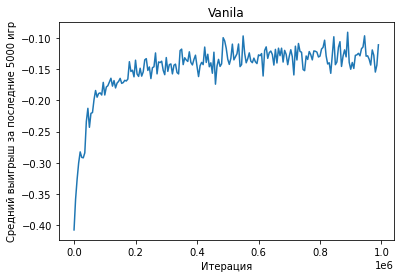

In [4]:
result_raw, pi_raw, env_raw, Q_raw = Q_learning(env=bj.BlackjackEnv(natural=True),
                                                get_s=get_s_basic,
                                                total_episodes=1000000,
                                                alpha=0.001,
                                                epsilon=0.25,
                                                gamma=0.01)

plt.plot([i*5000 for i in range(len(result_raw))], result_raw)
plt.title("Vanila")
plt.xlabel('Итерация')
plt.ylabel('Средний выигрыш за последние 5000 игр')
plt.show()


Как мы видим, у нас впоне пполучается обучаться. Я сильно уменьшил альфу что бы уменьшить дисперсию при обучении. Также я уменьшил гамму, поскольку в блэкджекее текущие действиия почти не влияют на последующие.

# 3

In [5]:
calculate_MC_reward(num_starts=1000000,
                    env=bj.BlackjackEnv(natural=True),
                    get_s=get_s_basic,
                    pi=pi_raw)

100%|██████████| 1000000/1000000 [00:47<00:00, 21127.11it/s]


-0.0347235


Получилось лучше, чеем у заданной в 1 задании схемы

# 4 Удвоенная игра

Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

Реализовано в файле blackjack_double.py

# 5

100%|██████████| 1000000/1000000 [01:25<00:00, 11750.69it/s]


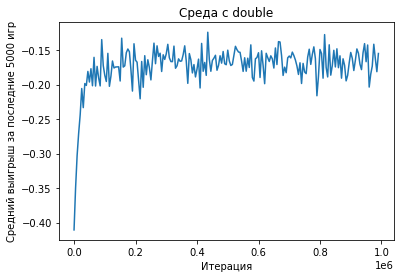

In [6]:
result_double, pi_double, env_double, Q_double = Q_learning(env=bj_double.BlackjackEnv(natural=True),
                                                   get_s=get_s_basic,
                                                   total_episodes=1000000,
                                                   alpha=0.01,
                                                   epsilon=0.25,
                                                   gamma=0.01)
plt.title("Среда с double")
plt.xlabel('Итерация')
plt.ylabel('Средний выигрыш за последние 5000 игр')
plt.plot([i*5000 for i in range(len(result_double))], result_double)
plt.show()

In [7]:
calculate_MC_reward(num_starts=1000000,
                    env=bj_double.BlackjackEnv(natural=True),
                    get_s=get_s_basic,
                    pi=pi_double)

100%|██████████| 1000000/1000000 [00:48<00:00, 20421.28it/s]


-0.02006


Получилось еще немного лучше.

# 6 Запоминание карт

Для ускоррения процесса обучения я убрал размерность пространства состояний, отвечающую за знание одной карты диллера. Эта информация в моем понимании дает не очень много, а вот количество состояний увеливает в целых 11 раз. Карты будем считать по системе Торпа из https://game-wiki.guru/published/blekdzhek/blekdzhek.-sistemyi-scheta-kart.html. Реализовано в файле blackjack_cards_remember.py

# 7

100%|██████████| 1000000/1000000 [03:15<00:00, 5116.87it/s]


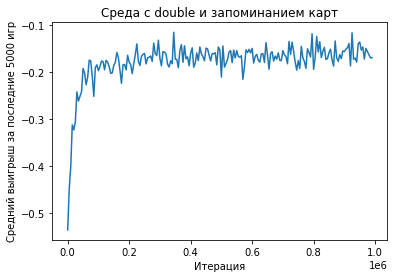

In [8]:
%autoreload 2
def get_s_count(s, env):
    return s[0]-1 + env.observation_space[0].n * s[1] + env.observation_space[0].n * env.observation_space[1].n * (s[2] + 76)

result_rem, pi_rem, env_rem, Q_rem = Q_learning(env=bj_rem.BlackjackEnv(natural=True),
                                                get_s=get_s_count,
                                                total_episodes=1000000,
                                                alpha=0.003,
                                                epsilon=0.25,
                                                gamma=0.01)
plt.title("Среда с double и запоминанием карт")
plt.xlabel('Итерация')
plt.ylabel('Средний выигрыш за последние 5000 игр')
plt.plot([i*5000 for i in range(len(result_rem))], result_rem)
plt.show()


In [9]:
calculate_MC_reward(num_starts=1000000,
                    env=bj_rem.BlackjackEnv(natural=True),
                    get_s=get_s_count,
                    pi=pi_rem)

100%|██████████| 1000000/1000000 [00:46<00:00, 21618.74it/s]

-0.0185905



Стало еще чуть-чуть лучше, но казино мы так и не обыграли.

# 9 Добавляеем возможность делать split

Попробуем обучить модель на среде, которая может делать split. Реализовано в blackjack_double_split.py.
Основные идеи:

1. Добавление split не только увеличит количество наших действий, но также и увеличит количество состояний в 12 раз(11 карт, которые могут быть раздеелены и 0, если сплитить нельзя) что бы совсем обучение не длилось совсем долго добавим эту возможность в среду с double, но без подсчета карт.
2. Нарушать правила не хорошо, поэтому пометим действие split из состояний, где split запрещен правилами в матрице Q очень большим по модулю отрицательным числом.
3. По факту после применения split мы получаем 2 одинаковые руки, что эквивалентно тому, что бы играть одну руку, начиная с одной картой и удваивать выигрышь(или проигрышь) в 2 раза.

100%|██████████| 1000000/1000000 [04:11<00:00, 3969.11it/s]


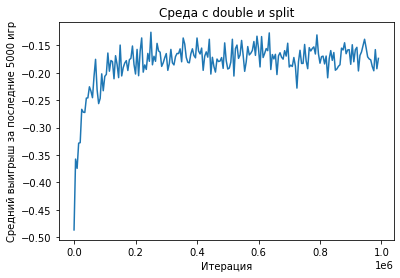

In [18]:
%autoreload 2
def get_s_split(s, env):
    return s[0]-1 + env.observation_space[0].n*(s[1]-1) + env.observation_space[0].n * env.observation_space[1].n * s[2] + env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n * s[3]

result_split, pi_split, env_aplit, Q_split = Q_learning(env=bj_split.BlackjackEnv(natural=True),
                                                get_s=get_s_split,
                                                total_episodes=1000000,
                                                alpha=0.005,
                                                epsilon=0.25,
                                                gamma=0.01,
                                                has_split=True)
plt.title("Среда с double и split")
plt.xlabel('Итерация')
plt.ylabel('Средний выигрыш за последние 5000 игр')
plt.plot([i*5000 for i in range(len(result_split))], result_split)
plt.show()

In [22]:
%autoreload 2
out = calculate_MC_reward(num_starts=1000000,
                    env=bj_split.BlackjackEnv(natural=True),
                    get_s=get_s_split,
                    pi=pi_split)

100%|██████████| 1000000/1000000 [01:06<00:00, 14931.83it/s]


-0.019415


Тут получился результат немного лучеш чем у double, но хуже, чем при счете карт.